In [1]:
from matplotlib import pyplot as plt
from matplotlib import colors, cm
from matplotlib.collections import LineCollection
from matplotlib.patches import Circle
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import trackpy as tp
import random as rand
from tqdm import tqdm
from scipy.optimize import curve_fit

In [2]:
def read_tuple_list(x):
    x_strip = x.strip('()').strip('[]')
    if len(x_strip.split(', ')) == 1:
        return np.array(x_strip.split(), dtype=float)
    else:
        return np.array(x_strip.split(', '), dtype=float)

In [3]:
#Defining a basic power law function to fit to our wave relations r^2:
def func_powerlaw(x, a, m):
    return m*x**a

In [4]:
#Defining a basic power law function to fit to our wave relations r^2:
def func_powerlaw_simple(x, a):
    return x**a

In [5]:
#To consolodate all the wave dataframes in a set, use the following function: 
#INPUT: Sorted list of all wave dataframe csv locations:
#Option to save the DF as a csv in the relevant location is given, default is False
#OUTPUT: A dataframe containing all of the csv wave DFs in the path list

def consolidate_waves(WAVE_DF_PATHS, save_DF = False):
    
    wave_collect = []

    for wave_df_path in tqdm(WAVE_DF_PATHS):
        img_id = int(wave_df_path.stem.split('_')[0]) #Get the image ID to match to the wave:
        wave_df = pd.read_csv(wave_df_path, converters={"wave_centroid": read_tuple_list}) #Open the wave_DF from step4 analysis
        wave_df = wave_df[wave_df.columns.drop(list(wave_df.filter(regex='Unnamed')))] #Strip it of any weird unnamed index columns
        track_ids = wave_df['clTrackID'].values #Get the collective track values in the wave
        wave_df['wave_ID'] = [str(img_id) + '-' + str(i) for i in track_ids] #Build a list of unique wave IDs from the image number and clTrack number they belong to
        wave_df['image_ID'] = [img_id for i in range(len(wave_df))]
        wave_collect.append(wave_df)
    
    wave_df_collected = pd.concat(wave_collect, ignore_index=True)
    
    if save_DF:
        wave_df_collected.to_csv(WAVE_DF_PATHS[0].parent / 'combined_wave_DF.csv', index=False)
        
    return wave_df_collected

In [6]:
#Lets import an arcos set, wave data, and the corresponding tracking data...
base_path = Path.cwd().parent / 'Data Sets/2024_02_14_dpi-1p5mm'
images_folder = base_path / 'images'
analysis_output_destination = base_path / 'wavefit_outputs'

wave_dataframe_paths = sorted(analysis_output_destination.glob('*_wave_df.csv'), key=lambda x: x.stem.split('_')[0])


In [7]:
wave_con_df = consolidate_waves(wave_dataframe_paths)
wave_con_df['real_time'] = wave_con_df['rel_time'] * 5.0

100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 434.59it/s]


In [15]:
wave_collect_for_travel = []


for wid, wave in wave_con_df.groupby('wave_ID'):
    linear_travel_collect = []
    mean_start = np.mean(wave.wave_centroid.values[0:6])

    for t, wave_i in wave.groupby('rel_time'):
        centroid_travel_distance = np.linalg.norm(wave_i.wave_centroid.values[0]-mean_start)
        total_linear_travel = wave_i.circle_radius.values[0] + centroid_travel_distance
        linear_travel_collect.append(total_linear_travel)

    wave['linear_travel'] = linear_travel_collect
    wave['linear_squared'] = [i**2 for i in linear_travel_collect]
    wave_collect_for_travel.append(wave)
    
waves_linear_added = pd.concat(wave_collect_for_travel, ignore_index=True)

/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

Text(0, 0.5, 'Radius (um)')

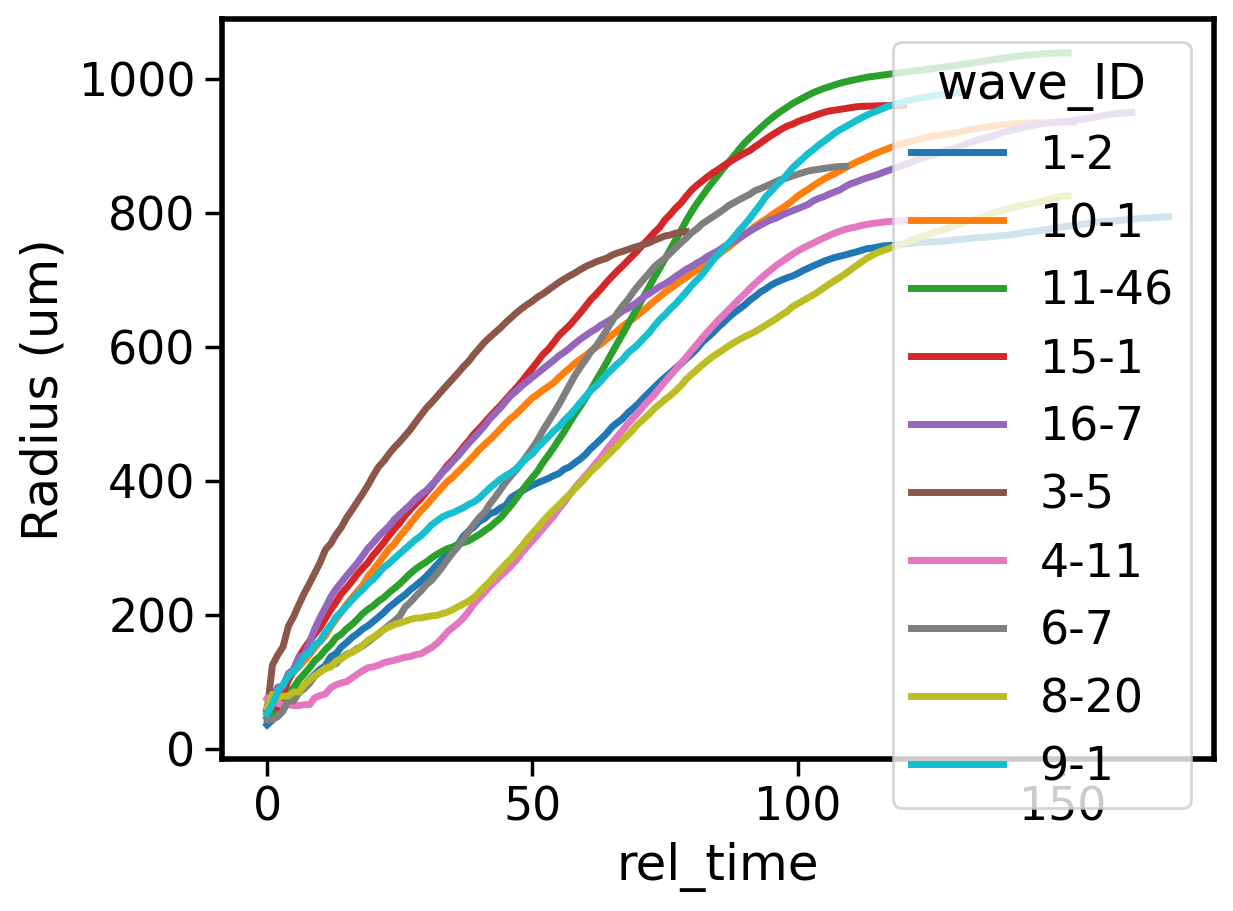

In [62]:
#Next are key wave analysis functions:
#Plotting all the waves in a set
plt.figure(dpi=200)
sns.lineplot(data=waves_linear_added[waves_linear_added['drug_name']=='DPI'], x='rel_time', y='linear_travel', hue='wave_ID')
plt.ylabel('Radius (um)')

In [78]:
dpi_only_DF = waves_linear_added[waves_linear_added['drug_name']=='DPI']

In [79]:
control_only_DF = waves_linear_added[waves_linear_added['drug_name']!='DPI']

In [80]:
roi_min_distance_to_edge = 740**2

In [81]:
#Cut out waves that exceed the minimum distance to the edge for power law fitting:

dpi_only_DF = dpi_only_DF[dpi_only_DF['linear_squared'] < roi_min_distance_to_edge]

In [82]:
dpi_only_DF.groupby('wave_ID').rel_r.max().min()

547.8422512035854

In [83]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5, 'font.family': ['arial'], 'axes.linewidth':2})


/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

Text(0, 0.5, '')

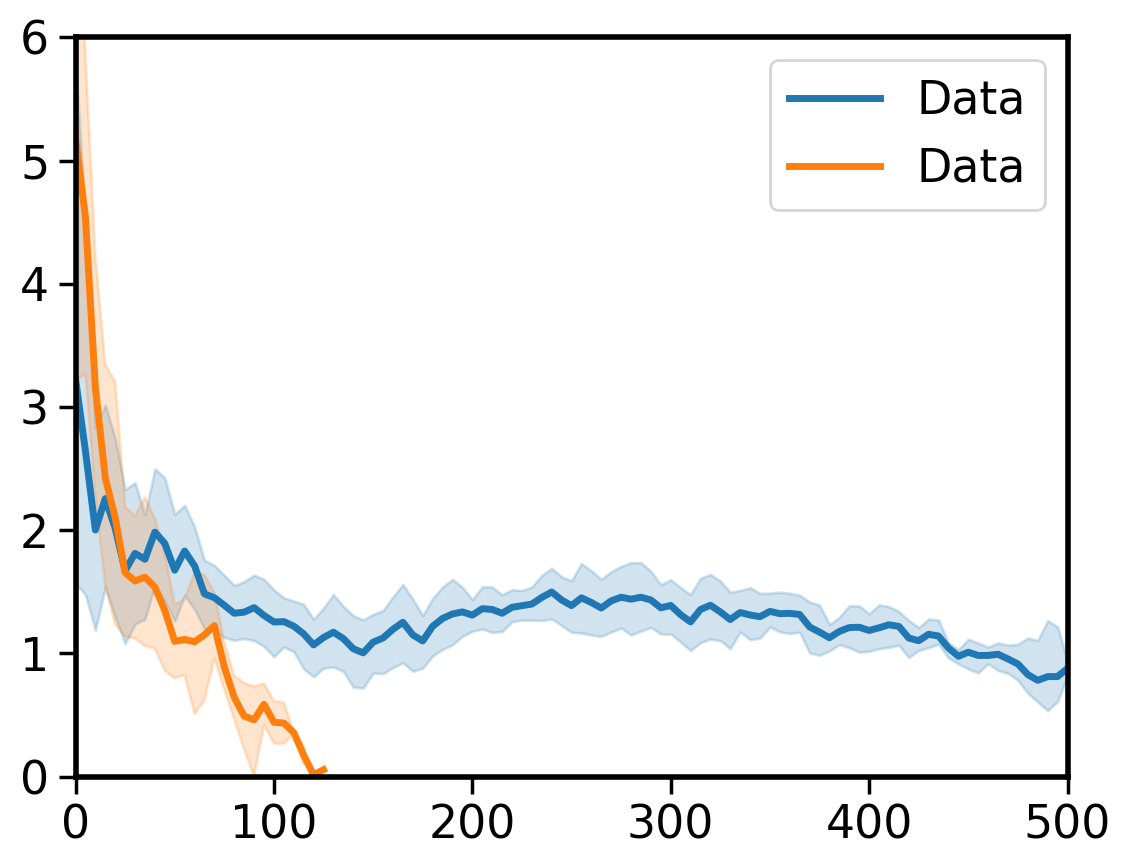

In [84]:

plt.figure(dpi=200)
sns.lineplot(data=dpi_only_DF,x='real_time', y='radius_velocity', label='Data')
sns.lineplot(data=control_only_DF,x='real_time', y='radius_velocity', label='Data')
plt.ylim(0,6)
plt.xlim(0,500)
plt.xlabel('')
plt.ylabel('')

In [113]:
wave_fits = []

for wid, wave in dpi_only_DF.groupby('wave_ID'):
    #Fit to our power law eq defined above where x=time, y=R^2
    #Because time will matter for fit, timestep to time is 5sec/frame:
    pars, cov = curve_fit(f=func_powerlaw, xdata=wave.real_time.values, ydata=wave.linear_squared.values, p0=[1, 100])
    wave_fits.append([wid, pars[0], pars[1]])

In [114]:
wave_fits_DF = pd.DataFrame(np.array(wave_fits, dtype=object), columns=['wid', 'alpha', 'm'])
wave_fits_DF['targets'] = '1.5mm'

/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

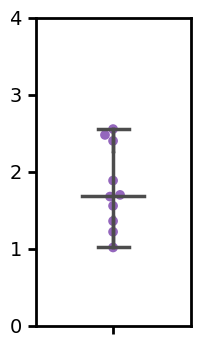

In [132]:
#Show distribution of alpha values for each DPI wave tracked: 

fig, ax = plt.subplots(figsize=(2,4))
sns.boxplot(data=wave_fits_DF, y='alpha', palette=[sns.color_palette()[7]],  width=0.001, ax=ax, zorder=10)
sns.boxplot(data=wave_fits_DF, y='alpha', palette=[sns.color_palette()[7]],  showbox=False, width=0.4, ax=ax, zorder=10)
sns.swarmplot(data=wave_fits_DF, y='alpha', palette=[sns.color_palette()[4]], size=7, ax=ax, zorder=-100)
ax.tick_params(direction='out', width=2, labelsize=14)
#plt.ylim(0,50000)
plt.xlabel('')
plt.xticks([0],[''])
plt.ylim(0,4)
plt.ylabel('')
plt.savefig('supplemental-fig3-dpi-indiv-fits_1p5mm-targets.png', dpi=300, bbox_inches='tight')

In [89]:
print('Alphas: {} +/- {}'.format(wave_fits_DF.alpha.mean(), wave_fits_DF.alpha.std()))
print('Volunteer N: {}'.format(str(len(dpi_only_DF['volunteer_ID'].unique()))))
print('Wave n: {}'.format(str(len(dpi_only_DF['wave_ID'].unique()))))

Alphas: 1.7817927949172099 +/- 0.5398616898499577
Volunteer N: 7
Wave n: 10


In [90]:
#Lets import an arcos set, wave data, and the corresponding tracking data...
base_path = Path.cwd().parent / 'Data Sets/2023_02_07_DPI-nadphox-inhib'
images_folder = base_path / 'images'
analysis_output_destination = base_path / 'wavefit_outputs'

wave_dataframe_paths_1mm = sorted(analysis_output_destination.glob('*_wave_df.csv'), key=lambda x: x.stem.split('_')[0])



In [91]:
wave_con_df_1mm = consolidate_waves(wave_dataframe_paths_1mm)
wave_con_df_1mm['real_time'] = wave_con_df_1mm['rel_time'] * 5.0

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 340.90it/s]


In [107]:
wave_collect_for_travel = []


for wid, wave in wave_con_df_1mm.groupby('wave_ID'):
    linear_travel_collect = []
    mean_start = np.mean(wave.wave_centroid.values[0:6])

    for t, wave_i in wave.groupby('rel_time'):
        centroid_travel_distance = np.linalg.norm(wave_i.wave_centroid.values[0]-mean_start)
        total_linear_travel = wave_i.circle_radius.values[0] + centroid_travel_distance
        linear_travel_collect.append(total_linear_travel)

    wave['linear_travel'] = linear_travel_collect
    wave['linear_squared'] = [i**2 for i in linear_travel_collect]
    wave_collect_for_travel.append(wave)
    
waves_linear_added_1mm = pd.concat(wave_collect_for_travel, ignore_index=True)

In [108]:
roi_min_distance_to_edge_1mm = 360**2

In [109]:
#Cut out waves that exceed the minimum distance to the edge for power law fitting:
dpi_only_DF_1mm = waves_linear_added_1mm[waves_linear_added_1mm['drug_name']=='DPI']
dpi_only_DF_1mm = dpi_only_DF_1mm[dpi_only_DF_1mm['linear_squared'] < roi_min_distance_to_edge_1mm]


In [111]:
wave_fits_1mm = []

for wid, wave in dpi_only_DF_1mm.groupby('wave_ID'):
    #Fit to our power law eq defined above where x=time, y=R^2
    #Because time will matter for fit, timestep to time is 5sec/frame:
    pars, cov = curve_fit(f=func_powerlaw, xdata=wave.real_time.values, ydata=wave.linear_squared.values, p0=[1, 100])
    wave_fits_1mm.append([wid, pars[0], pars[1]])
    
wave_fits_DF_1mm = pd.DataFrame(np.array(wave_fits_1mm, dtype=object), columns=['wid', 'alpha', 'm'])
wave_fits_DF_1mm['targets'] = '1mm'

/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

Text(-30.375, 0.5, '')

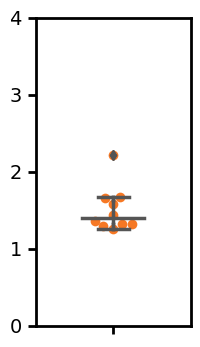

In [101]:
#Show distribution of alpha values for each DPI wave tracked: 

fig, ax = plt.subplots(figsize=(2,4))
sns.boxplot(data=wave_fits_DF_1mm, y='alpha', color=sns.color_palette('Oranges')[3],  width=0.001, ax=ax, zorder=10)
sns.boxplot(data=wave_fits_DF_1mm, y='alpha', color=sns.color_palette('Oranges')[3],  showbox=False, width=0.4, ax=ax, zorder=10)
sns.swarmplot(data=wave_fits_DF_1mm, y='alpha', color=sns.color_palette('Oranges')[3], size=7, ax=ax, zorder=-100)
ax.tick_params(direction='out', width=2, labelsize=14)
#plt.ylim(0,50000)
plt.xlabel('')
plt.xticks([0],[''])
plt.ylim(0,4)
plt.ylabel('')

In [116]:
combo_DPI_fits = pd.concat([wave_fits_DF_1mm, wave_fits_DF], ignore_index=True)

In [136]:
sns.color_palette('Purples')

[(0.9265974625144175, 0.919769319492503, 0.9557093425605536),
 (0.8207612456747405, 0.8218992695117262, 0.9044982698961938),
 (0.6878892733564014, 0.6835832372164552, 0.829834678969627),
 (0.5513264129181085, 0.537916186082276, 0.7524490580545944),
 (0.440722798923491, 0.36772010765090346, 0.6653902345251825),
 (0.3405767012687428, 0.1742560553633218, 0.5709342560553633)]

/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

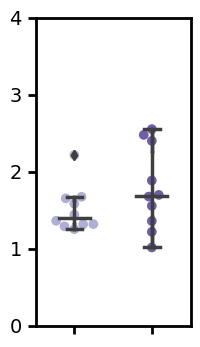

In [140]:
#Show distribution of alpha values for each DPI wave tracked: 

fig, ax = plt.subplots(figsize=(2,4))
sns.boxplot(data=combo_DPI_fits, x='targets', y='alpha', palette=[sns.color_palette()[0],sns.color_palette()[4]],  width=0.001, ax=ax, zorder=10)
sns.boxplot(data=combo_DPI_fits, x='targets', y='alpha', palette=[sns.color_palette()[0],sns.color_palette()[4]],  showbox=False, width=0.4, ax=ax, zorder=10)
sns.swarmplot(data=combo_DPI_fits, x='targets', y='alpha', palette=[sns.color_palette('Purples')[2],sns.color_palette('Purples')[4]], size=7, ax=ax, zorder=-100)
ax.tick_params(direction='out', width=2, labelsize=14)
#plt.ylim(0,50000)
plt.xlabel('')
plt.xticks([0,1],['',''])
plt.ylim(0,4)
plt.ylabel('')
plt.savefig('supplemental-fig3-dpi-indiv-fits_both-targets.png', dpi=300, bbox_inches='tight')

In [144]:
dpi_only_DF_1mm[dpi_only_DF_1mm['drug_name'] == 'DPI'].wave_ID.unique()

array(['0-1', '1-1', '10-1', '11-1', '3-4', '4-1', '5-1', '7-1', '8-1',
       '9-2'], dtype=object)

In [145]:
dpi_only_DF_1mm[dpi_only_DF_1mm['drug_name'] == 'DPI'].volunteer_ID.unique()

array([19,  8, 18])